In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multitest import fdrcorrection
dpath_lip = "../data/sars-cov-2-LiP/20210430_084806_lgillet_SARS2_NSP9_LiP_SpecLib_Report.xls"
dpath_TC = "../data/sars-cov-2-LiP/20210430_084629_lgillet_SARS2_NSP9_TC_SpecLib_Report.xls"

df_lip = pd.read_csv(dpath_lip, delimiter="\t")

/Users/ajipalar/anaconda3/envs/pynet/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
#Intensity FG.MS2RawQuantity
#Make Synthetic Data
#log2FC = log2(mean(n))-log2(mean(n2))
#Pvalue
#fdr < 0.01 FDR
#anova(aov(pep_imputed_intensity))

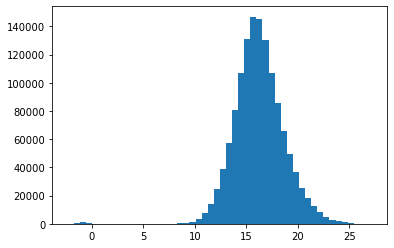

In [3]:
plt.hist(np.log2(df_lip['FG.MS2RawQuantity']), bins=50)
plt.show()

In [198]:
len(df_lip)

1311994

In [258]:
# Generate Synthetic Data
means_selector = np.random.randint(0, len(df_lip), 100000)
means = df_lip['FG.MS2RawQuantity'][means_selector]
means = np.log2(means).values
cvs = np.array([0.1, 0.11, 0.12, 0.15, 0.13, 0.2, 0.16])


def triplet(mu, cv):
    return mu + cv*mu*np.random.randn(3)
def min_max(x):
    return min(x), max(x)

def synthetic_triplet(means, cvs, npeptides=32000):
    mu = []
    sigma = []
    for i in range(npeptides):
        #Select one of the two distributions
        b = np.random.binomial(n=1, p=0.001)
        if b:
            meany = np.random.randint(2, 10)
        else:
            meany = np.random.randint(0, 2)
        mu.append(meany)
        cv = np.random.randint(0, len(cvs))
        sigma.append(cv)
        
    #Array of means
    means=means[mu]
    #Array of cvs
    cvs = cvs[sigma]
    
    #Initialize treatment
    treatment = np.zeros((npeptides, 3))
    wt = np.zeros((npeptides, 3))
    for i in range(npeptides):
        effect = np.random.binomial(n=1, p=0.01)
        wt_triplet = triplet(means[i], cvs[i])
        
        if effect:
            i2 = np.random.randint(0, len(means))
        else:
            i2 = i
        treatment_triplet = triplet(means[i2], cvs[i2])
        if effect:
            treatment_triplet = treatment_triplet*100
        treatment[i] = treatment_triplet
        
        wt[i] = wt_triplet
    return wt, treatment
            

log2data = 16.131 + 2.407*np.random.randn(3, 64000)
wt = log2data[:, 0:32000]
treat = log2data[:, 32000:]
assert treat.shape == wt.shape
aov_p_val = f_oneway(treat, wt)[1]
adjusted_p_val = fdrcorrection(aov_p_val)
log2_fc = np.mean(treat, axis=0) - np.mean(wt, axis=0)

"""
def sets(df):
    s = []
    for col in df:
        s.append(set(df[col]))
    return s

selector = ['R.Condition', 'R.FileName', 'R.Fraction', 'R.Label',
           'R.Replicate']
s = sets(df_lip[selector])
s
"""
wt, treatment = synthetic_triplet(means, cvs)
log2_fc_synth = np.mean(treatment, axis=1) - np.mean(wt, axis=1)
pval_synth = f_oneway(treatment, wt, axis=1)[1]
fdr_adj_pval = fdrcorrection(pval_synth, alpha=0.01)[1]
conformotypic = np.logical_and(np.abs(log2_fc_synth) >=2, -np.log10(fdr_adj_pval)>=2)

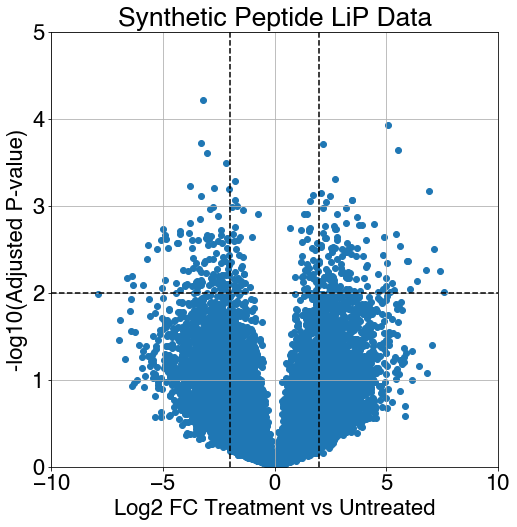

In [291]:
import matplotlib
%matplotlib inline

def plot_figure(x, y):
    # Font
    font = {'family' : 'Helvetica',
            'weight' : 'bold',
            'size'   : 22}

    matplotlib.rc('font', **font)

    xlim = 10
    ylim = 5
    line_dict = {'colors':'k','linestyle':'dashed' }
    figsize=(8,8)
    plt.figure(figsize=figsize)
    plt.scatter(x, -np.log10(y))
    plt.xlim((-xlim, xlim))
    #plt.vlines([-2, 2], 0, 7, colors='k')
    plt.ylim(0, ylim)
    plt.vlines([-2, 2], 0, ylim, **line_dict)
    plt.hlines([2], -xlim, xlim , **line_dict)
    plt.grid()
    plt.title("Synthetic Peptide LiP Data")
    plt.xlabel("Log2 FC Treatment vs Untreated")
    plt.ylabel("-log10(Adjusted P-value)")
    plt.show()
plot_figure(log2_fc_synth, pval_synth)

<ErrorbarContainer object of 3 artists>

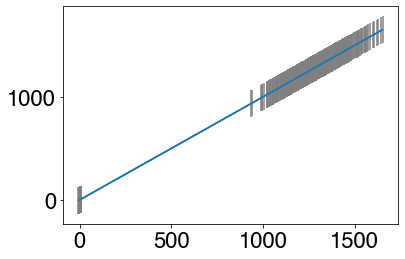

In [272]:
error_d = {'yerr':np.std(treatment), 'ecolor':'grey'}
plt.errorbar(log2_fc_synth, log2_fc_synth, **error_d )

In [358]:
def reshape(x, npep=npep, ngen=ngen):
    return np.repeat(x, ngen).reshape(npep, ngen)

def Rhat(I_k, mu, sigma, ngen):
    
    #I_k npep x 3
    # I = R*A
    # A ~ Norm(mu, sigma)
    npep = len(I_k)
    reshape = lambda x: reshape(x, npep=npep, ngen=ngen)
    sigma = reshape(sigma)
    mu = reshape(mu)
    A = np.random.randn(npep, ngen)*sigma + mu #Pep
    
    #I
    I_sig = np.std(I_k, axis=1) #npep
    I_mu = np.mean(I_k, axis=1)
    I_sig = reshape(I_sig)
    I_mu = reshape(I_mu)
    
    I = np.random.randn(npep, ngen)*I_sig + I_mu #npep
    
    #npep x ngen
    r = 10**(np.log10(I) - np.log10(A))
    return r #npep x ngen

def Ahat(I, r):
    #A = I / R
    #Npep x 3
    
    return a_k0

def stochastic_model(log2_I_wt, log2_I_treat, prior_mu, prior_sigma, n_generated_samples=3):
    size = len(log2_I_wt)
    #size x 1
    
    #mu size , sigma # size
    
    # A_hat size x generated_samples
    meds = np.median(2**log2_I_wt, axis=1)
    std = np.std(2**log2_I_wt, axis=1)
    print(std.shape)
    std_cat = np.concatenate([std]*n_generated_samples)
    print(std_cat.shape)
    
    A_ko_hat = np.concatenate([meds]*n_generated_samples) + np.random.randn(size, n_generated_samples)*std_cat
    A_p_wt_hat = prior_mu + 10**(np.log10(np.random.randn(size)) + np.log10(prior_sigma))
    
    R_hat = np.log2(Ik_wt) - np.log2(A_p_wt_hat)
    Ak_hat = R_hat + log2_I_treat
    y_hat = 1
    return y_hat

mu = np.mean(2**wt, axis=1)
sigma = np.std(2**wt, axis=1)
stochastic_model(wt, treatment, mu, sigma )

SyntaxError: invalid syntax (1934762901.py, line 27)

/var/folders/pb/1n044l6123x12jb4461p386r0000gn/T/ipykernel_51611/2105334929.py:22: RuntimeWarning: invalid value encountered in log10
  r = 10**(np.log10(I) - np.log10(A))


(32000, 4)

In [324]:
np.concatenate((wt, wt), axis=1)

array([[14.47154332, 15.73779089, 13.09804398, 14.47154332, 15.73779089,
        13.09804398],
       [10.82715786, 12.17632962, 10.74961545, 10.82715786, 12.17632962,
        10.74961545],
       [16.27892566, 13.60428517, 14.73214807, 16.27892566, 13.60428517,
        14.73214807],
       ...,
       [15.41449136, 13.00992722, 12.80797322, 15.41449136, 13.00992722,
        12.80797322],
       [12.94457692, 13.71732107, 11.19019774, 12.94457692, 13.71732107,
        11.19019774],
       [ 9.98489016, 13.92008199, 13.1687875 ,  9.98489016, 13.92008199,
        13.1687875 ]])

5

In [165]:
def fdr(parray, test=False):
    # Get positions of all entries
    position_dict = {}
    for i,j in enumerate(parray):
        position_dict[j]=i
    #Sort the pvalues in ascending order
    parray = parray.copy()
    parray.sort()
    m = len(parray)
    adjusted_p_val = np.zeros(m)
    #Adjust the p values
    for i,j in enumerate(parray):
        k = i+1
        adjusted_p_val[i] = parray[i]*m/k
    empty = np.zeros(m)
    if test:
        input_array = parray
    else:
        input_array = adjusted_p_val
    for i, j in enumerate(adjusted_p_val):
        old_val= parray[i]
        old_pos=position_dict[old_val]
        empty[old_pos] = input_array[i]
    return empty
x = np.random.randn(1000,)
x2 = fdr(x, test=True)
assert (x==x2).sum() == len(x)
del x
del x2
aov_adjusted_p_val = fdr(aov_p_val)

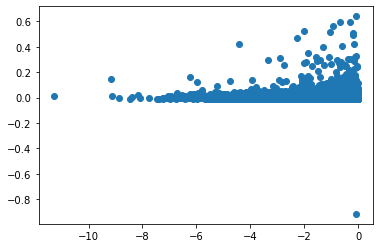

In [154]:
x = aov_p_val.copy()
x.sort()
plt.scatter(np.log(x), np.log(aov_adjusted_p_val))

Text(0, 0.5, '-log10(FDR adjusted p value)')

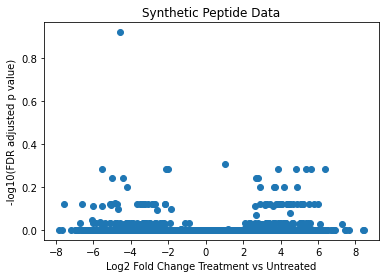

In [170]:
plt.scatter(log2_fc, -np.log10(adjusted_p_val[1]))
plt.title("Synthetic Peptide Data")
plt.xlabel("Log2 Fold Change Treatment vs Untreated")
plt.ylabel("-log10(FDR adjusted p value)")

In [65]:
?np.random.randn